<a href="https://colab.research.google.com/github/DucBox/Finger-Classification/blob/main/Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Module

In [1]:
import joblib
import pickle
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from keras.regularizers import l2
from keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical

# Load and Prepare data

In [3]:
df = pd.read_pickle("/content/drive/MyDrive/FingerClassification/Data/data_final1.pkl")

In [4]:
df = df.sort_values(by='Timestamp', ascending=True)

In [5]:
#Làm phẳng mỗi mảng 2 chiều và tạo mảng 2 chiều cho việc scale
X_flattened = np.array([blob.flatten() for blob in df['Resized_Blobs'].values])

#Normalization
min_max_scaler = MinMaxScaler()

X_min_max_scaled = min_max_scaler.fit_transform(X_flattened)
df['New'] = list(X_min_max_scaled)

area_scaled = min_max_scaler.fit_transform(df['Area'].values.reshape(-1, 1))
df['Area'] = area_scaled

In [6]:
#Split Data
split_factor = 0.8
ptcp_train = df.Participant.unique()[:math.floor(len(df.Participant.unique())*split_factor)]
ptcp_test = df.Participant.unique()[math.floor(len(df.Participant.unique())*split_factor):]
df_train = df[df.Participant.isin(ptcp_train)].copy(deep=True)
df_test = df[df.Participant.isin(ptcp_test)].copy(deep=True)

In [7]:
le = LabelEncoder()

X_train = np.stack(df_train[['New', 'Area']].values)
X_test = np.stack(df_test[['New', 'Area']].values)

X_train_features = np.array([sample[0] for sample in X_train])
X_train_area = np.array([sample[1] for sample in X_train])

X_test_features = np.array([sample[0] for sample in X_test])
X_test_area = np.array([sample[1] for sample in X_test])

In [8]:
#Encode
y_train = df_train['Handedness'].values
y_test = df_test['Handedness'].values
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

#One-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [16]:
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Activation, BatchNormalization,
    Conv2D, MaxPool2D, Input, Concatenate
)
from tensorflow.keras.models import Sequential, load_model, Model
#Define input
input_shape_new = (64,)
input_shape_area = (1,)

# Input Layer
input_new = Input(shape=input_shape_new, name='input_new')
input_area = Input(shape=input_shape_area, name='input_area')

x = Dense(128)(input_new)
x = BatchNormalization()(x)
x = Activation('relu')(x)

y = Dense(128)(input_area)
y = BatchNormalization()(y)
y = Activation('relu')(y)

# Merge Layer
merged = Concatenate()([x,y])

# Hidden layer
merged = Dense(64)(merged)
merged = BatchNormalization()(merged)
merged = Activation('relu')(merged)

merged = Dense(32)(merged)
merged = BatchNormalization()(merged)
merged = Activation('relu')(merged)

merged = Dense(16)(merged)
merged = BatchNormalization()(merged)
merged = Activation('relu')(merged)

#Output Layer
output = Dense(2, activation='softmax')(merged)

model = Model(inputs=[input_new, input_area], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(name='accuracy')])

#Check
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_new (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 input_area (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 128)                  8320      ['input_new[0][0]']           
                                                                                                  
 dense_7 (Dense)             (None, 128)                  256       ['input_area[0][0]']          
                                                                                            

In [15]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

# Training

In [17]:
checkpoint = ModelCheckpoint('/content/model_2.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 50, verbose=0)

history = model.fit([X_train_features, X_train_area], y_train_one_hot,
                    validation_data=([X_test_features,X_test_area], y_test_one_hot),
                    epochs=100, batch_size=16, callbacks=[checkpoint, early_stopping])

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/history.csv', index=False)


Epoch 1/100
4734/4734 [==============================] - 51s 10ms/step - loss: 0.4638 - accuracy: 0.7759 - val_loss: 0.4595 - val_accuracy: 0.7912
Epoch 2/100
4734/4734 [==============================] - 39s 8ms/step - loss: 0.3981 - accuracy: 0.8170 - val_loss: 0.3185 - val_accuracy: 0.8578
Epoch 3/100
4734/4734 [==============================] - 33s 7ms/step - loss: 0.3768 - accuracy: 0.8298 - val_loss: 0.3394 - val_accuracy: 0.8529
Epoch 4/100
4734/4734 [==============================] - 22s 5ms/step - loss: 0.3634 - accuracy: 0.8372 - val_loss: 0.2924 - val_accuracy: 0.8749
Epoch 5/100
4734/4734 [==============================] - 25s 5ms/step - loss: 0.3528 - accuracy: 0.8422 - val_loss: 0.3367 - val_accuracy: 0.8493
Epoch 6/100
4734/4734 [==============================] - 24s 5ms/step - loss: 0.3437 - accuracy: 0.8482 - val_loss: 0.2950 - val_accuracy: 0.8707
Epoch 7/100
4734/4734 [==============================] - 24s 5ms/step - loss: 0.3349 - accuracy: 0.8497 - val_loss: 0.3206 

# Evaluating



In [19]:
best_model = load_model('/content/model_2.h5')

loss, accuracy = best_model.evaluate([X_test_features, X_test_area], y_test_one_hot, verbose=0)

print(f"Best model test loss: {loss}")
print(f"Best model test accuracy: {accuracy}")

Best model test loss: 0.210096538066864
Best model test accuracy: 0.9128461480140686


# Visualize Training Process

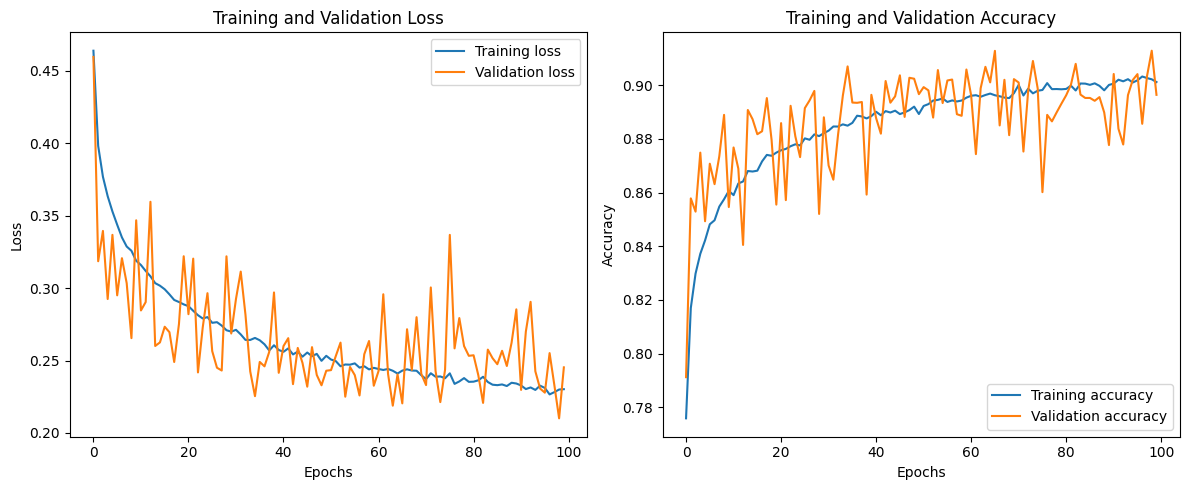

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Vẽ đồ thị loss
ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Vẽ đồ thị accuracy
ax[1].plot(history.history['accuracy'], label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()